In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
%matplotlib inline

In [3]:
points = np.load('/data/hok/testdata/fastsc/GM_k9_10000pts.npy')

# scikit-learn kmeans

In [4]:
from sklearn.cluster import k_means

In [5]:
%time centroids, skkm_labels, intertia = k_means(points, n_clusters=9)

CPU times: user 114 ms, sys: 1.8 ms, total: 116 ms
Wall time: 114 ms


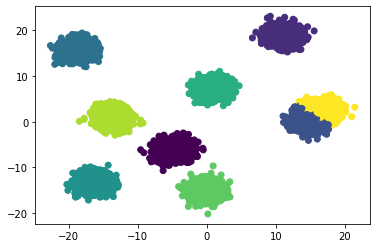

In [6]:
plt.scatter(points[:, 0], points[:, 1], c=skkm_labels)

# scikit-learn SpectralClustering

In [7]:
from sklearn.cluster import SpectralClustering

In [8]:
%time sklearn_sc = SpectralClustering(n_clusters=9, assign_labels='kmeans', random_state=0).fit(points)

CPU times: user 55.1 s, sys: 3.17 s, total: 58.2 s
Wall time: 58.2 s


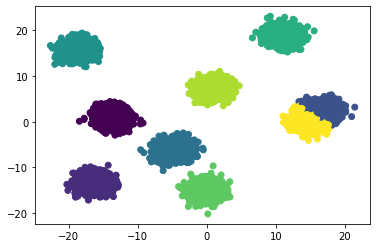

In [9]:
plt.scatter(points[:, 0], points[:, 1], c=sklearn_sc.labels_)

# SeqSC

In [10]:
from pyseqsc import seq_sc

In [11]:
from scipy.spatial.distance import euclidean

In [12]:
from functools import partial

In [13]:
expdecay_kernel = lambda x1, x2, sigma: np.exp(-0.5*euclidean(x1, x2)/(sigma*sigma)) 

In [14]:
%time centroids, seqsc_labels = seq_sc(points, 9, 9, partial(expdecay_kernel, sigma=0.1), int(points.shape[0]/10))

/data/hok/conda/envs/hokdev/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


CPU times: user 4.77 s, sys: 121 ms, total: 4.89 s
Wall time: 4.76 s


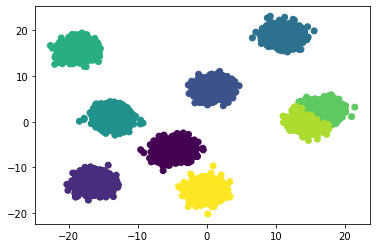

In [15]:
plt.scatter(points[:, 0], points[:, 1], c=seqsc_labels)

# Silhoutte Scores

In [16]:
import numba

In [17]:
@numba.njit(numba.float64(numba.int64, numba.float64[:], numba.int64[:]))
def calculate_mean_cluster_intradistance_onepoint(datum_index, distance_vector, cluster_labels):
    label = cluster_labels[datum_index]
    clustersize = np.sum(cluster_labels == label)
    return np.sum(distance_vector[cluster_labels == label]) / (clustersize - 1)


@numba.njit(numba.float64(numba.int64, numba.float64[:], numba.int64[:]))
def calculate_mean_nearest_cluster_distance(datum_index, distance_vector, cluster_labels):
    label = cluster_labels[datum_index]
    all_cluster_labels = set(cluster_labels)
    cluster_distances = np.zeros(len(all_cluster_labels))
    for cluster_label in all_cluster_labels:
        if cluster_label == label:
            cluster_distances[cluster_label] = np.inf
            continue
        cluster_distances[cluster_label] = np.mean(distance_vector[cluster_labels == cluster_label])
    return np.min(cluster_distances)


def calculate_cached_silhoutte_score(distance_matrix_generator_func, cluster_labels):
    nbdata = len(cluster_labels)
    scores = np.zeros(nbdata)

    for i, distance_vector in enumerate(distance_matrix_generator_func()):
        try:
            a = calculate_mean_cluster_intradistance_onepoint(i, distance_vector, cluster_labels)
        except ZeroDivisionError:
            scores[i] = 0.
            continue
        b = calculate_mean_nearest_cluster_distance(i, distance_vector, cluster_labels)
        scores[i] = (b - a) / max(a, b)

    return scores

/data/hok/conda/envs/hokdev/lib/python3.7/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [19]:
from itertools import product

distance_matrix = np.zeros((points.shape[0], points.shape[0]))
for i, j in product(range(points.shape[0]), range(points.shape[0])):
    distance_matrix[i, j] = euclidean(points[i], points[j])

In [21]:
def distance_matrix_generator(distance_matrix):
    for i in range(len(distance_matrix)):
        yield distance_matrix[i, :]

In [26]:
scores = calculate_cached_silhoutte_score(partial(distance_matrix_generator, distance_matrix=distance_matrix),
                                          np.array(seqsc_labels, dtype=np.int))

In [27]:
np.mean(scores)

0.7371519795106477

In [28]:
test_distance_matrix = np.array([[0., 0.1, 0.9, 0.8],
                                 [0.1, 0., 1.1, 0.9],
                                 [0.9, 1.1, 0., 0.02],
                                 [0.8, 0.9, 0.02, 0.]])

In [31]:
scores = calculate_cached_silhoutte_score(partial(distance_matrix_generator, distance_matrix=test_distance_matrix),
                                          np.array([0, 1, 0, 1], dtype=np.int))

In [32]:
np.mean(scores)

-0.4388888888888889